In [2]:
import numpy as np
import matplotlib.pyplot as plt
import urllib
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from datetime import datetime
import glob

usingColab = True

# If using google colab change boolean above to True
if usingColab:
    from google.colab import drive
    drive.mount('/content/drive')

    # If using google colab change this path to the folder that this file is in make sure there is no slash on the end!!!
    %cd /content/drive/MyDrive/Msc Artificial Intelligence/Semester 1/Deep Neural Networks and Learning Systems/Assignment

Mounted at /content/drive
/content/drive/MyDrive/Msc Artificial Intelligence/Semester 1/Deep Neural Networks and Learning Systems/Assignment


In [9]:
# Copied load model function from assingment file to use to load model logs
def loadModel(folderPath):

  with open(f'{folderPath}summaryDictionary.pkl', 'rb') as f:
    summary = pickle.load(f)

  with open(f'{folderPath}logs.pkl', 'rb') as f:
    modelLogs = pickle.load(f)

  model = torch.load(f'{folderPath}model.pt', 'cuda' if torch.cuda.is_available() else 'cpu')

  return model, modelLogs, summary

In [4]:
# Gets all models saved in the local models folder
modelPaths = glob.glob("./models/*")
modelPaths

['./models/2(7)-2(413696)-Adam-0.001-cosine~similarity-200-128-71.7-51.73-02 01 2024.00 58 01',
 './models/2(7)-2(206848)-Adam-0.001-cosine~similarity-200-128-63.25-52.29-02 01 2024.00 58 47',
 './models/2(22)-6(704384)-Adam-0.001-cosine~similarity-200-128-67.15-51.71-deep-03 01 2024.02 05 44',
 './models/2(22)-3(33136640)-Adam-0.001-cosine~similarity-200-128-98.04-51.61-wide-03 01 2024.02 07 43',
 './models/4(118)-3(2349824)-Adam-0.001-cosine~similarity-200-128-74.11-52.55-03 01 2024.16 18 58',
 './models/2(36)-3(2695616)-Adam-0.001-cosine~similarity-200-128-74.22-52.0-03 01 2024.16 34 14',
 './models/2(22)-3(2332752)-Adam-0.001-cosine~similarity-200-128-79.45-52.43-03 01 2024.16 29 55']

In [5]:
# Defines class so models can be loaded without error
class FullNetwork(nn.Module):

  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 6, 5)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(6, 16, 5)
      self.fc1 = nn.Linear(16 * 29 * 29, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 8428)

  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [10]:
# Loads each model into an array
models = []

for path in modelPaths:
    models.append(loadModel(path + '/'))

In [12]:
# Finds all occurences of a parsed substring (used to find "-"'s)
# This is used to cut unhelpful data out of the model name before displaying on the graph
def findAll(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub)

In [13]:
def PlotGraphs(models, modelPaths, conditions, filePrefix=""):
    # Plots a given amount of models to a loss, training and validation accuracy graphs

    # Creates 3 subplots for the 3 graphs
    figLoss = plt.figure(figsize=(6, 5))
    s1 = figLoss.add_subplot(111)
    figTrain = plt.figure(figsize=(6, 5))
    s2 = figTrain.add_subplot(111)
    figVal = plt.figure(figsize=(6, 5))
    s3 = figVal.add_subplot(111)

    # Goes through each model with their respective path
    for model, name in zip(models, modelPaths):

        # Checks for conditions in the name so that certain models can be plotted and others ignored
        for condition in conditions:
            if condition in name:

                dashIndexes = findAll(name, "-")
                dashIndexes = list(dashIndexes)

                # Plots the model log data
                s1.plot(np.arange(0, model[1]['epochs']), model[1]['loss'], label=name[9:dashIndexes[-1]])

                s2.plot(np.arange(0, model[1]['epochs']), model[1]['training'], label=(name[9:dashIndexes[-1]] + " Training"))
                s3.plot(np.arange(0, model[1]['epochs']), model[1]['validation'], label=(name[9:dashIndexes[-1]] + " Validation"))

                break

    # As the legends are so big they need to be above the graph which is what this does
    # If you try this out and the legend is inside the graph try increasing the second argument in the bbox_to_anchor parameter
    s1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), fancybox=True, shadow=True)
    s1.set_title("Loss")

    s2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), fancybox=True, shadow=True)
    s2.set_title("Training Accuracy")

    s3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), fancybox=True, shadow=True)
    s3.set_title("Validation Accuracy")

    # Saves graphs to send over to the latex file
    figLoss.savefig(f"./figures/{filePrefix}loss.png", bbox_inches='tight', pad_inches=0.2)
    figTrain.savefig(f"./figures/{filePrefix}train.png", bbox_inches='tight', pad_inches=0.2)
    figVal.savefig(f"./figures/{filePrefix}val.png", bbox_inches='tight', pad_inches=0.2)

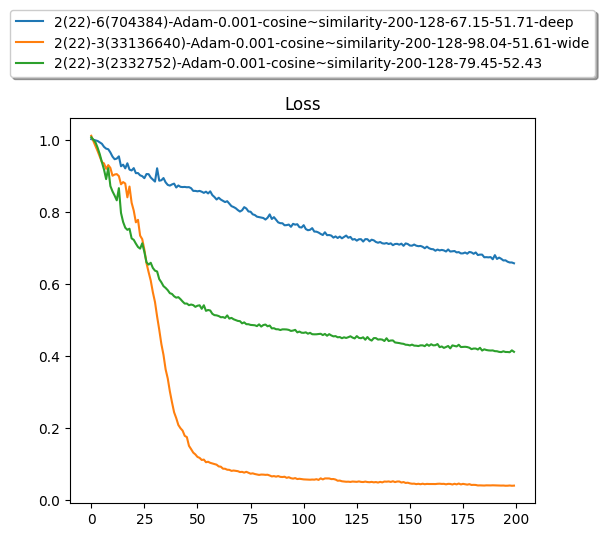

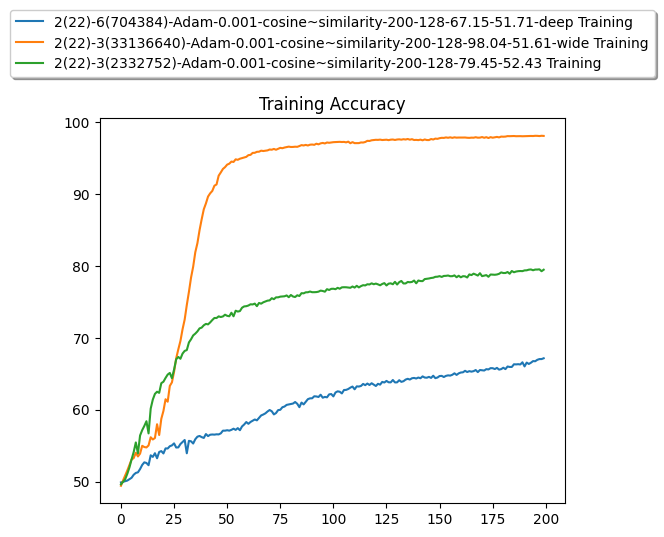

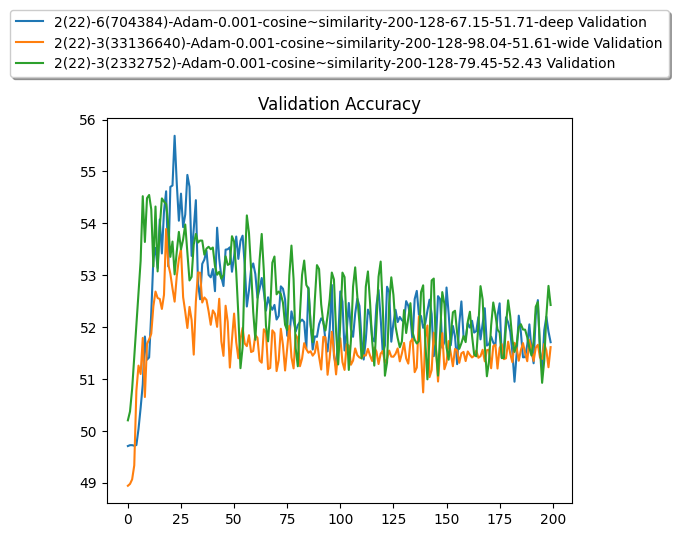

In [16]:
# Call plot graph function
PlotGraphs(models, modelPaths, conditions=["2(22)"], filePrefix="regul")